# Task 3, Homework 3 - Machine Learning
## Classification for Imbalanced Data
Split the data using a technique suitable for imbalanced classes. Describe its working.

Train a logistic regression model on the below data.

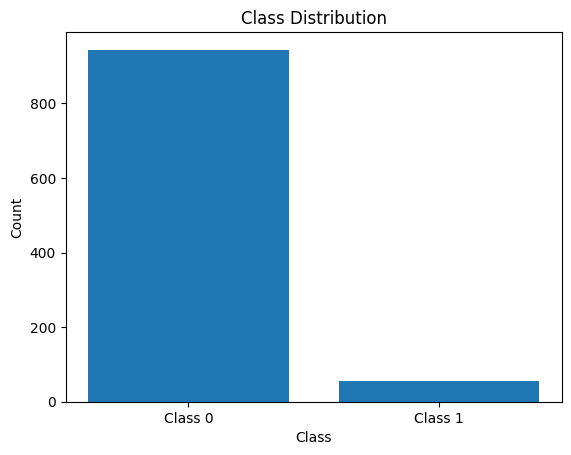

Dataset Shape: (1000, 20)
Class Distribution: [944  56]


In [19]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np

# Create a synthetic dataset
X, y = make_classification(
    n_samples=1000,
    n_informative=4, n_redundant=5, n_features=20, n_clusters_per_class=3,
    n_classes=2,
    weights=[0.95, 0.05],
    random_state=42
)

# Visualize class distribution
def visualize_class_distribution(y):
    plt.bar(['Class 0', 'Class 1'], [sum(y == 0), sum(y == 1)])
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

visualize_class_distribution(y)

# Summarize dataset
print("Dataset Shape:", X.shape)
print("Class Distribution:", np.bincount(y))


### How to properly split the data?
We will use `Stratified Split`, which is optimal for dealing with inbalanced data. 
- It ensures that both training and test datasets maintain the same proportion of each class as in the original dataset.
- It also ensures that we don't learn too little from the minority class

We will use `stratify=y` parameter in basic `train_test_split` function

### Implementation
We will start by copying Logistic Regression function from previous task

In [20]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def gradient_descent(X, y, learning_rate=0.01, iterations=1000):
    N, K = X.shape
    beta = np.zeros(K)
    
    for _ in range(iterations):
        predictions = sigmoid(np.dot(X, beta))
        gradient = np.dot(X.T, (y - predictions)) / N
        beta += learning_rate * gradient
    return beta

### Train and predict
Here we will train the model and generate data for evaluation. In second part of the task we are asked to write our own evaluation functions, I will do that later

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Stratified split
beta = gradient_descent(X_train, y_train, learning_rate=0.01, iterations=1000) # Train using custom gradient descent
y_pred = sigmoid(np.dot(X_test, beta)) > 0.5 # Make predictions
y_prob = sigmoid(np.dot(X_test, beta))  # Needed for ROC-AUC function

## Second part of the task - evaluation
Evaluate your binary classifiers using the following:
- confusion matrix,
- accuracy,
- precision,
- recall,
- F1 score,
- ROCAUC.

Please write custom functions calculating the above functions and plotting the receiver operating characteristic curve. Describe your intuition behind each metric and its suitability for imbalanced classes.

### Evaluation functions
We are asked to write six different functions and evaluate model. Let's start by explaining what each function does and writing function definitions:
- Confusion Matrix
  - Breakdown of predictions, useful for finding type of error (f.e. low accuracy on the minority class)
- Accuracy
  - Average accuracy for entire model, might be misleading in unbalanced dataset
- Precision
  - Amount of predicted positives that are true positives - good for avoiding false positives in minority class
- Recall
  - How well does model find positive instances (how low is amount of positives that are missed) - not missing minority class
- F1 Score
  - Balance between precision and recall - high F1 means both high precision and high recall
- ROC-AUC
  - Most advanced metric here, ideal for imbalanced classes

I have also written evaluation function, that takes test data and preditions to display those metrics

In [35]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

def confusion_matrix_func(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return TP, TN, FP, FN

def accuracy(TP, TN, FP, FN):
    return (TP + TN) / (TP + TN + FP + FN)

def precision(TP, FP):
    return TP / (TP + FP) if (TP + FP) != 0 else 0

def recall(TP, FN):
    return TP / (TP + FN) if (TP + FN) != 0 else 0

def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

def evaluate(test, pred, plot=False):
    TP, TN, FP, FN = confusion_matrix_func(test, pred)

    accuracy_value = accuracy(TP, TN, FP, FN)
    precision_value = precision(TP, FP)
    recall_value = recall(TP, FN)
    f1_value = f1_score(precision_value, recall_value)
    
    if plot:
        roc_auc_value = plot_roc_curve(y_test, y_prob)
    else:
        roc_auc_value = roc_auc_score(test, pred) 

    return TP, TN, FP, FN, accuracy_value, precision_value, recall_value, f1_value, roc_auc_value

def print_evaluation(TP, TN, FP, FN, accuracy_value, precision_value, recall_value, f1_value, roc_auc_value):
    print(f"Confusion Matrix: TP={TP}, TN={TN}, FP={FP}, FN={FN}")
    print(f"Accuracy: {accuracy_value:.4f}")
    print(f"Precision: {precision_value:.4f}")
    print(f"Recall: {recall_value:.4f}")
    print(f"F1 Score: {f1_value:.4f}")
    print(f"ROC AUC: {roc_auc_value:.4f}")

### Usage of evaluation functions
Let's use evaluation functions and analyze it's findings.

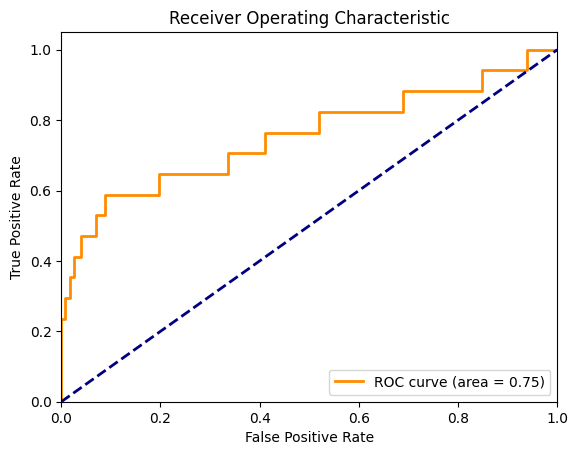

Confusion Matrix: TP=10, TN=233, FP=50, FN=7
Accuracy: 0.8100
Precision: 0.1667
Recall: 0.5882
F1 Score: 0.2597
ROC AUC: 0.7537


In [36]:
TP, TN, FP, FN, accuracy_value, precision_value, recall_value, f1_value, roc_auc_value = evaluate(y_test, y_pred, plot=True)
print_evaluation(TP, TN, FP, FN, accuracy_value, precision_value, recall_value, f1_value, roc_auc_value)

### Analyzing evaluation data 
Our accuracy is quite high, but a look at Precision/Recall/F1 Score tells a different story. Accuracy is carried by the majority class, but our model struggles with dealing with the minority class.

Confussion matrix shows us that the main problem is with false positives.

ROC shows us that our model is better than random guessing, but there is still area for improvement.

### Conclussion from part 2
Main takeaway that we can have from there is that just accuracy is often not enough for unbalanced data.

## Part 3 of the task
Propose, describe and implement a technique for improving the model's ability to distinguish the classes. Evaluate your approach.

### Solution: Adjusting the decision threshold
I will solve this problem by testing different decision thresholds and selecting one providing us best results. I will try thresholds from 0.05 to 0.95 and then analyze which one provides us with the best results.

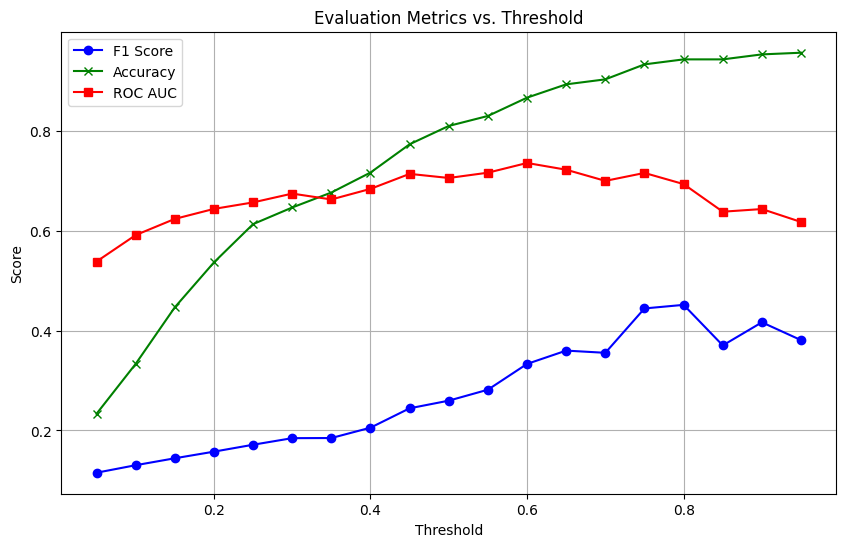

In [42]:
import numpy as np
import matplotlib.pyplot as plt

f1_scores = []
accuracies = []
roc_auc_scores = []
thresholds = []

for threshold in np.arange(0.05, 1.0, 0.05):
    y_pred = sigmoid(np.dot(X_test, beta)) > threshold
    TP, TN, FP, FN, accuracy_value, precision_value, recall_value, f1_value, roc_auc_value = evaluate(y_test, y_pred)
    
    f1_scores.append(f1_value)
    accuracies.append(accuracy_value)
    roc_auc_scores.append(roc_auc_value)
    thresholds.append(threshold)

plt.figure(figsize=(10, 6))

plt.plot(thresholds, f1_scores, label='F1 Score', color='blue', marker='o')
plt.plot(thresholds, accuracies, label='Accuracy', color='green', marker='x')
plt.plot(thresholds, roc_auc_scores, label='ROC AUC', color='red', marker='s')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Evaluation Metrics vs. Threshold')
plt.legend()
plt.grid(True)

plt.show()

### Conclussion for part 3
As we can see, adjusting decision threshold is a viable option to fix issues created by class imbalance. (And we also found that accuracy would be a really bad metric to use here). F1 Score never gets really high, but we have increased it twofold (while ROC stays similar). We can see on the graph that the best decision threshold for this specific problem is about `0.75`